In [236]:
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()

# Functions

# Importing Data

In [237]:

def bref_batter(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.batting_stats_bref(year)
            print(f"Batter Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_pitcher(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.pitching_stats_bref(year)
            print(f"Pitcher Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_fielder(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.statcast_outs_above_average(year, "all", 0)
            print(f"Fielding Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def per_game_data(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.season_game_logs(year)
            print(f"Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df




def Main_Scrape(date1,date2):

    batter_data=bref_batter(date1,date2)

    pitcher_data=bref_pitcher(date1,date2)

    fielder_data=bref_fielder(date1,date2)
    batter_data.to_csv('./Lahman_compiled_player_data/batter_data.csv', index=False)
    pitcher_data.to_csv('./Lahman_compiled_player_data/pitcher_data.csv', index=False)
    fielder_data.to_csv('./Lahman_compiled_player_data/fielder_data.csv', index=False)
    return batter_data,fielder_data,pitcher_data



def Main_Import(per_game_path,batter_path,pitcher_path,fielder_path):
    # Save the dataframes to csv files
    per_game_data=pd.read_csv(per_game_path, header=0)
    batter_data=pd.read_csv(batter_path, header=0)
    pitcher_data=pd.read_csv(pitcher_path, header=0)
    fielder_data=pd.read_csv(fielder_path, header=0)
    chad = pyb.chadwick_register(save=True)
    return batter_data,pitcher_data,fielder_data, per_game_data, chad

def fetch_data_bwar(date1, date2, per_game_path):
    import pybaseball as pyb
    import pandas as pd

    # fielder_data = bref_fielder(date1, date2)
    batter_bwar_data = pyb.bwar_bat()
    pitcher_bwar_data = pyb.bwar_pitch()
    per_game_data = pd.read_csv(per_game_path, header=0)
    chad = pyb.chadwick_register(save=True)
    # return fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad
    return batter_bwar_data, pitcher_bwar_data, per_game_data, chad

# Formatting player data

In [238]:
#Remove columns with an NaN above a certain level
def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]
from sklearn.preprocessing import LabelEncoder

#Turn columns with letters in them to numbers
def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df
    
#Turn mlbid into retro id
def process_dataframe(df, index_column, chad, chad_key_column, chad_value_column):
    df = df.set_index(index_column)
    chad_dict = chad.set_index(chad_key_column)[chad_value_column].to_dict()
    df.index = df.index.map(chad_dict)
    return df

# Formatting per game data

In [239]:
def process_per_game_data(per_game_data):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_ID'] = per_game_data['Date'].astype(str) + per_game_data['HmTm'] + per_game_data['VisTm']

    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()

# Set the new index
    per_game_data.set_index('Game_ID', inplace=True)

    # List of columns to keep
    columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns']

    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]

    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)
    per_game_data['home_odds'] = -110
    per_game_data['visiting_odds']= -110
    
    return per_game_data

def process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded):
    # Replace player_ids with their stats and add new columns for each stat
    for column in player_id_columns:
        if 'PchID' in column:  # If the column is for a pitcher
            stats = per_game_data_reduced[column].map(pitcher_bwar_encoded)
        else:  # If the column is for a batter
            stats = per_game_data_reduced[column].map(batter_bwar_encoded)

        # Add new columns for each stat
        for stat_name in stats.iloc[0].keys():
            per_game_data_reduced[column + '_' + stat_name] = stats.apply(lambda x: x[stat_name] if isinstance(x, dict) else np.nan)

        # Drop the original column
        per_game_data_reduced.drop(column, axis=1, inplace=True)
    
    return per_game_data_reduced

def split_data(per_game_data_reduced, train_year, test_year):
    # Create a mask for the training set
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

    # Split the data into training and testing sets
    X_train = per_game_data_reduced[train_mask].drop('winner', axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)

    X_test = per_game_data_reduced[test_mask].drop('winner', axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']
    
    return X_train, y_train, X_test, y_test

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method, fill_value=0)
    # Fit and transform all columns
    df[:] = imputer.fit_transform(df)
    return df

# Set-up Neural Network

In [240]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data
        X_train, X_valid = X[train_indices], X[valid_indices]
        y_train, y_valid = y[train_indices], y[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

#CALL THE MODEL
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model

    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)


#Luck Accuracy calculation
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients for this
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    return accuracy

# Predict the outcome of the season and calculate profit

In [241]:
class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance

    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data):
        # Ensure the bettor has enough money in the wallet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]
        
        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]
        
        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']
            
            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds
            
            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)
            
            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)

        return self.wallet
    
def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped



Epoch 1: 100%|██████████| 228/228 [00:01<00:00, 218.70it/s]


Training Loss: 0.9270655769005156
Validation Loss: 0.6832087824219152


Epoch 2: 100%|██████████| 228/228 [00:00<00:00, 235.93it/s]


Training Loss: 0.706361643316453
Validation Loss: 0.6841905618968763


Epoch 3: 100%|██████████| 228/228 [00:01<00:00, 219.70it/s]


Training Loss: 0.690501689126617
Validation Loss: 0.6733630534849668


Epoch 4: 100%|██████████| 228/228 [00:00<00:00, 236.36it/s]


Training Loss: 0.6850382923557047
Validation Loss: 0.6640249004489497


Epoch 5: 100%|██████████| 228/228 [00:00<00:00, 236.07it/s]


Training Loss: 0.6751199369890648
Validation Loss: 0.6501534314532029


Epoch 6: 100%|██████████| 228/228 [00:00<00:00, 239.79it/s]


Training Loss: 0.6534603957021445
Validation Loss: 0.6379766401491667


Epoch 7: 100%|██████████| 228/228 [00:00<00:00, 240.23it/s]


Training Loss: 0.6100546696729827
Validation Loss: 0.484614729097015


Epoch 8: 100%|██████████| 228/228 [00:00<00:00, 234.58it/s]


Training Loss: 0.5337588421085424
Validation Loss: 0.38693184601633174


Epoch 9: 100%|██████████| 228/228 [00:01<00:00, 225.64it/s]


Training Loss: 0.44181300791209205
Validation Loss: 0.29505029124648946


Epoch 10: 100%|██████████| 228/228 [00:00<00:00, 238.77it/s]


Training Loss: 0.3445567588011424
Validation Loss: 0.1926171638463673


Epoch 11: 100%|██████████| 228/228 [00:00<00:00, 231.25it/s]


Training Loss: 0.2965142846499619
Validation Loss: 0.17787573859095573


Epoch 12: 100%|██████████| 228/228 [00:00<00:00, 239.45it/s]


Training Loss: 0.25310494809558515
Validation Loss: 0.12451715061539098


Epoch 13: 100%|██████████| 228/228 [00:00<00:00, 239.35it/s]


Training Loss: 0.22018571273145968
Validation Loss: 0.1385112786175389


Epoch 14: 100%|██████████| 228/228 [00:01<00:00, 227.54it/s]


Training Loss: 0.18909447079753144
Validation Loss: 0.0859055245099099


Epoch 15: 100%|██████████| 228/228 [00:00<00:00, 229.90it/s]


Training Loss: 0.17023355245851635
Validation Loss: 0.09975475072860718


Epoch 16: 100%|██████████| 228/228 [00:01<00:00, 205.58it/s]


Training Loss: 0.17024047581250207
Validation Loss: 0.0837585473139035


Epoch 17: 100%|██████████| 228/228 [00:01<00:00, 227.85it/s]


Training Loss: 0.1267238361352499
Validation Loss: 0.061519956804419816


Epoch 18: 100%|██████████| 228/228 [00:01<00:00, 226.40it/s]


Training Loss: 0.12717150560204396
Validation Loss: 0.0750531142479495


Epoch 19: 100%|██████████| 228/228 [00:01<00:00, 225.53it/s]


Training Loss: 0.12294304402741163
Validation Loss: 0.0312730989075805


Epoch 20: 100%|██████████| 228/228 [00:01<00:00, 219.67it/s]


Training Loss: 0.09015983162578523
Validation Loss: 0.03724858836319886


Epoch 21: 100%|██████████| 228/228 [00:00<00:00, 235.77it/s]


Training Loss: 0.08167598595058448
Validation Loss: 0.016703899349331072


Epoch 22: 100%|██████████| 228/228 [00:01<00:00, 212.10it/s]


Training Loss: 0.09156025522143434
Validation Loss: 0.04369952774753696


Epoch 23: 100%|██████████| 228/228 [00:00<00:00, 237.77it/s]


Training Loss: 0.057362859535619225
Validation Loss: 0.018626332356545486


Epoch 24: 100%|██████████| 228/228 [00:00<00:00, 230.58it/s]


Training Loss: 0.08940200744147755
Validation Loss: 0.07506144968302626


Epoch 25: 100%|██████████| 228/228 [00:01<00:00, 215.92it/s]


Training Loss: 0.09755043768152398
Validation Loss: 0.025690486875215645


Epoch 26: 100%|██████████| 228/228 [00:00<00:00, 233.62it/s]


Training Loss: 0.07155467904981617
Validation Loss: 0.011120657828685484


Epoch 27: 100%|██████████| 228/228 [00:00<00:00, 231.34it/s]


Training Loss: 0.06643642307965804
Validation Loss: 0.015245542763487288


Epoch 28: 100%|██████████| 228/228 [00:00<00:00, 233.98it/s]


Training Loss: 0.06533829927477136
Validation Loss: 0.09497180301696062


Epoch 29: 100%|██████████| 228/228 [00:00<00:00, 233.44it/s]


Training Loss: 0.0909264111858711
Validation Loss: 0.017798515392075245


Epoch 30: 100%|██████████| 228/228 [00:00<00:00, 234.76it/s]


Training Loss: 0.06403496719308589
Validation Loss: 0.007725637418365008


Epoch 31: 100%|██████████| 228/228 [00:01<00:00, 198.20it/s]


Training Loss: 0.05808462090422645
Validation Loss: 0.029621171716012452


Epoch 32: 100%|██████████| 228/228 [00:00<00:00, 235.75it/s]


Training Loss: 0.05137611978499448
Validation Loss: 0.0524738174127905


Epoch 33: 100%|██████████| 228/228 [00:00<00:00, 229.10it/s]


Training Loss: 0.059502421310498266
Validation Loss: 0.02282777072028502


Epoch 34: 100%|██████████| 228/228 [00:00<00:00, 233.26it/s]


Training Loss: 0.06197907351439394
Validation Loss: 0.05346785838666715


Epoch 35: 100%|██████████| 228/228 [00:01<00:00, 216.65it/s]


Training Loss: 0.06933745687721264
Validation Loss: 0.09030602715517345
Early stopping triggered
Confusion Matrix:
[[1142    1]
 [   2 1284]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1286

    accuracy                           1.00      2429
   macro avg       1.00      1.00      1.00      2429
weighted avg       1.00      1.00      1.00      2429

22969.677132530614


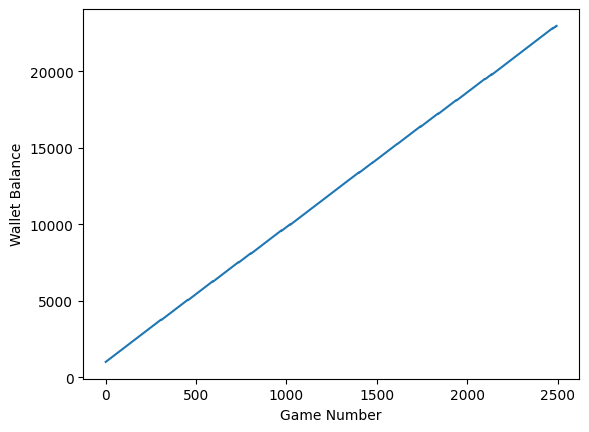

In [242]:
#Training and testing years for the machine learning model
test_year = '2019'
train_year = [str(year) for year in range(int(test_year) - 6, int(test_year))]


#Use this to update data from the websites (has data starting from 2008)
date1=2008
date2=2024

#Do not use this unless you want to go back to the old data
# batter_data,pitcher_data,fielder_data=Main_Scrape(2008,2024)

# get the register data and save to disk


#After scraping the files are saved locally. Also, the per_game_data is found manually and imported
per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'
batter_path='./Lahman_compiled_player_data/batter_data.csv'
pitcher_path='./Lahman_compiled_player_data/pitcher_data.csv'
fielder_path='./Lahman_compiled_player_data/fielder_data.csv'
# _,_,fielder_data, per_game_data, chad = Main_Import(per_game_path,batter_path,pitcher_path,fielder_path)


#New Bwar data scraping
# fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)
batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)

# Use the function to remove columns with more than 40% NaN values
batter_bwar_data = remove_columns_with_nan(batter_bwar_data, 40)
pitcher_bwar_data = remove_columns_with_nan(pitcher_bwar_data, 40)
# fielder_data = remove_columns_with_nan(fielder_data, 40)

batter_bwar_data = process_dataframe(batter_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
pitcher_bwar_data = process_dataframe(pitcher_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
# fielder_data = process_dataframe(fielder_data, 'player_id', chad, 'key_mlbam', 'key_retro')

batter_bwar_encoded = label_encode(batter_bwar_data)
batter_bwar_grouped = batter_bwar_encoded.groupby('mlb_ID').mean()
batter_bwar_reduced=batter_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','player_ID','team_ID','pitcher'])
batter_bwar_dict = batter_bwar_reduced.T.to_dict()


pitcher_bwar_encoded = label_encode(pitcher_bwar_data)
pitcher_bwar_grouped = pitcher_bwar_encoded.groupby('mlb_ID').mean()
pitcher_bwar_reduced=pitcher_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','team_ID','player_ID'])
pitcher_bwar_dict = pitcher_bwar_reduced.T.to_dict()
# fielder_encoded = fielder_encoded.T.to_dict()

#Drops unnecessary columns
per_game_data_reduced = process_per_game_data(per_game_data)
test_purposes=process_per_game_data(per_game_data)
# List of columns containing player_ids
player_id_columns = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']


#replaces player_ids with their player_stats
# for_test_purposes = process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded)
per_game_data_reduced = process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
test_purposes = process_player_data(test_purposes, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
#Removes columns with more than 40%
per_game_data_reduced = remove_columns_with_nan(per_game_data_reduced, 40)
#replaces nan with 0s

per_game_data_imputed=Impute(per_game_data_reduced,'constant')

#splits the data into 
X_train, y_train, X_test, y_test = split_data(per_game_data_imputed, train_year, test_year)

#my code is bad so the model needs to be called again after the cross validater
model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)


# print("Cross-validation scores: ", scores)
# print("Cross-validation scores average: ", np.mean(scores))
# print("Standard deviation of cross-validation score: ", np.std(scores))
# model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)

train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion)





ok, bets, skipped = predict_game_outcome(X_test.index, X_test.values, model, True, 10, 1)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)
for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_data_imputed)

print(better.wallet)
# Plot the wallet balance over time
plt.plot(better.wallet_history)
plt.xlabel('Game Number')
plt.ylabel('Wallet Balance')
plt.show()

In [243]:
print(bets)

[9.959607720375061, 9.800580739974976, 9.999136924743652, 10.0, 9.999948740005493, 9.823862314224243, 10.0, 9.99416708946228, 9.99948501586914, 9.992238283157349, 9.99783456325531, 10.0, 9.999997615814209, 10.0, 9.999982118606567, 10.0, 9.999457597732544, 9.682055115699768, 10.0, 9.999998807907104, 9.999827146530151, 9.999973773956299, 9.814167618751526, 9.9972003698349, 10.0, 10.0, 10.0, 9.998847246170044, 9.996263980865479, 9.770324230194092, 9.999970197677612, 9.996448755264282, 9.963646531105042, 9.997132420539856, 9.999693632125854, 9.722251892089844, 9.996182918548584, 9.999443292617798, 9.99997854232788, 9.999998807907104, 9.978559613227844, 9.999996423721313, 9.906182885169983, 9.999995231628418, 9.985346794128418, 8.027899265289307, 9.999990463256836, 10.0, 9.996836185455322, 9.9718576669693, 9.99623417854309, 9.994803071022034, 9.872501492500305, 9.990432858467102, 10.0, 9.99114453792572, 9.999022483825684, 10.0, 9.996380805969238, 10.0, 9.997166991233826, 9.96630609035492, 1

In [244]:
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 99.88%


In [245]:

pd.set_option('display.max_columns', None)
test_purposes.head(1)

,HmRuns,VisRuns,winner,home_odds,visiting_odds,HmStPchID_G,HmStPchID_GS,HmStPchID_RA,HmStPchID_xRA,HmStPchID_BIP,HmStPchID_BIP_perc,HmStPchID_ERA_plus,HmStPchID_WAR_rep,HmStPchID_WAA,HmStPchID_WAA_adj,HmStPchID_WAR,VisStPchID_G,VisStPchID_GS,VisStPchID_RA,VisStPchID_xRA,VisStPchID_BIP,VisStPchID_BIP_perc,VisStPchID_ERA_plus,VisStPchID_WAR_rep,VisStPchID_WAA,VisStPchID_WAA_adj,VisStPchID_WAR,HmBat1ID_G,HmBat1ID_PA,HmBat1ID_runs_above_avg,HmBat1ID_runs_above_avg_off,HmBat1ID_runs_above_avg_def,HmBat1ID_WAR_rep,HmBat1ID_WAA,HmBat1ID_WAR,HmBat2ID_G,HmBat2ID_PA,HmBat2ID_runs_above_avg,HmBat2ID_runs_above_avg_off,HmBat2ID_runs_above_avg_def,HmBat2ID_WAR_rep,HmBat2ID_WAA,HmBat2ID_WAR,HmBat3ID_G,HmBat3ID_PA,HmBat3ID_runs_above_avg,HmBat3ID_runs_above_avg_off,HmBat3ID_runs_above_avg_def,HmBat3ID_WAR_rep,HmBat3ID_WAA,HmBat3ID_WAR,HmBat4ID_G,HmBat4ID_PA,HmBat4ID_runs_above_avg,HmBat4ID_runs_above_avg_off,HmBat4ID_runs_above_avg_def,HmBat4ID_WAR_rep,HmBat4ID_WAA,HmBat4ID_WAR,HmBat5ID_G,HmBat5ID_PA,HmBat5ID_runs_above_avg,HmBat5ID_runs_above_avg_off,HmBat5ID_runs_above_avg_def,HmBat5ID_WAR_rep,HmBat5ID_WAA,HmBat5ID_WAR,HmBat6ID_G,HmBat6ID_PA,HmBat6ID_runs_above_avg,HmBat6ID_runs_above_avg_off,HmBat6ID_runs_above_avg_def,HmBat6ID_WAR_rep,HmBat6ID_WAA,HmBat6ID_WAR,HmBat7ID_G,HmBat7ID_PA,HmBat7ID_runs_above_avg,HmBat7ID_runs_above_avg_off,HmBat7ID_runs_above_avg_def,HmBat7ID_WAR_rep,HmBat7ID_WAA,HmBat7ID_WAR,HmBat8ID_G,HmBat8ID_PA,HmBat8ID_runs_above_avg,HmBat8ID_runs_above_avg_off,HmBat8ID_runs_above_avg_def,HmBat8ID_WAR_rep,HmBat8ID_WAA,HmBat8ID_WAR,HmBat9ID_G,HmBat9ID_PA,HmBat9ID_runs_above_avg,HmBat9ID_runs_above_avg_off,HmBat9ID_runs_above_avg_def,HmBat9ID_WAR_rep,HmBat9ID_WAA,HmBat9ID_WAR,VisBat1ID_G,VisBat1ID_PA,VisBat1ID_runs_above_avg,VisBat1ID_runs_above_avg_off,VisBat1ID_runs_above_avg_def,VisBat1ID_WAR_rep,VisBat1ID_WAA,VisBat1ID_WAR,VisBat2ID_G,VisBat2ID_PA,VisBat2ID_runs_above_avg,VisBat2ID_runs_above_avg_off,VisBat2ID_runs_above_avg_def,VisBat2ID_WAR_rep,VisBat2ID_WAA,VisBat2ID_WAR,VisBat3ID_G,VisBat3ID_PA,VisBat3ID_runs_above_avg,VisBat3ID_runs_above_avg_off,VisBat3ID_runs_above_avg_def,VisBat3ID_WAR_rep,VisBat3ID_WAA,VisBat3ID_WAR,VisBat4ID_G,VisBat4ID_PA,VisBat4ID_runs_above_avg,VisBat4ID_runs_above_avg_off,VisBat4ID_runs_above_avg_def,VisBat4ID_WAR_rep,VisBat4ID_WAA,VisBat4ID_WAR,VisBat5ID_G,VisBat5ID_PA,VisBat5ID_runs_above_avg,VisBat5ID_runs_above_avg_off,VisBat5ID_runs_above_avg_def,VisBat5ID_WAR_rep,VisBat5ID_WAA,VisBat5ID_WAR,VisBat6ID_G,VisBat6ID_PA,VisBat6ID_runs_above_avg,VisBat6ID_runs_above_avg_off,VisBat6ID_runs_above_avg_def,VisBat6ID_WAR_rep,VisBat6ID_WAA,VisBat6ID_WAR,VisBat7ID_G,VisBat7ID_PA,VisBat7ID_runs_above_avg,VisBat7ID_runs_above_avg_off,VisBat7ID_runs_above_avg_def,VisBat7ID_WAR_rep,VisBat7ID_WAA,VisBat7ID_WAR,VisBat8ID_G,VisBat8ID_PA,VisBat8ID_runs_above_avg,VisBat8ID_runs_above_avg_off,VisBat8ID_runs_above_avg_def,VisBat8ID_WAR_rep,VisBat8ID_WAA,VisBat8ID_WAR,VisBat9ID_G,VisBat9ID_PA,VisBat9ID_runs_above_avg,VisBat9ID_runs_above_avg_off,VisBat9ID_runs_above_avg_def,VisBat9ID_WAR_rep,VisBat9ID_WAA,VisBat9ID_WAR
Game_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000329NYNCHN,3,5,0,-110,-110,26.1875,22.1875,72.3125,74.440812,467.875,0.1038,104.985911,1.204381,0.197819,-0.110419,1.291875,28.642857,23.357143,82.714286,83.625571,519.5,0.116971,103.078375,1.354736,0.574321,-0.107229,1.821429,106.241379,460.206897,23.103448,20.87931,-1.124138,1.457586,2.375172,3.832759,88.533333,345.133333,-0.16,0.326667,-0.44,1.119333,-0.004667,1.114667,115.846154,469.846154,9.6,8.315385,3.807692,1.416923,0.795385,2.212308,106.222222,430.277778,21.372222,24.883333,1.277778,1.316111,1.991111,3.307222,122.294118,486.529412,16.935294,7.805882,10.517647,1.623529,1.674706,3.298235,110.0,460.727273,-0.690909,0.809091,-3.718182,1.387273,-0.185455,1.201818,102.761905,411.857143,-2.885714,0.433333,-2.961

In [246]:
scores = cross_validate(model, X_train.values, y_train.values)
print("Cross-validation scores: ", scores)
print("Cross-validation scores average: ", np.mean(scores))
print("Standard deviation of cross-validation score: ", np.std(scores))

Cross-validation scores:  [0.894718792866941, 0.9945130315500685, 0.9489026063100137, 0.9938271604938271, 0.9646655231560892]
Cross-validation scores average:  0.9593254228753878
Standard deviation of cross-validation score:  0.03671431905985952


In [247]:
X_test

,HmRuns,VisRuns,home_odds,visiting_odds,HmStPchID_G,HmStPchID_GS,HmStPchID_RA,HmStPchID_xRA,HmStPchID_BIP,HmStPchID_BIP_perc,HmStPchID_ERA_plus,HmStPchID_WAR_rep,HmStPchID_WAA,HmStPchID_WAA_adj,HmStPchID_WAR,VisStPchID_G,VisStPchID_GS,VisStPchID_RA,VisStPchID_xRA,VisStPchID_BIP,VisStPchID_BIP_perc,VisStPchID_ERA_plus,VisStPchID_WAR_rep,VisStPchID_WAA,VisStPchID_WAA_adj,VisStPchID_WAR,HmBat1ID_G,HmBat1ID_PA,HmBat1ID_runs_above_avg,HmBat1ID_runs_above_avg_off,HmBat1ID_runs_above_avg_def,HmBat1ID_WAR_rep,HmBat1ID_WAA,HmBat1ID_WAR,HmBat2ID_G,HmBat2ID_PA,HmBat2ID_runs_above_avg,HmBat2ID_runs_above_avg_off,HmBat2ID_runs_above_avg_def,HmBat2ID_WAR_rep,HmBat2ID_WAA,HmBat2ID_WAR,HmBat3ID_G,HmBat3ID_PA,HmBat3ID_runs_above_avg,HmBat3ID_runs_above_avg_off,HmBat3ID_runs_above_avg_def,HmBat3ID_WAR_rep,HmBat3ID_WAA,HmBat3ID_WAR,HmBat4ID_G,HmBat4ID_PA,HmBat4ID_runs_above_avg,HmBat4ID_runs_above_avg_off,HmBat4ID_runs_above_avg_def,HmBat4ID_WAR_rep,HmBat4ID_WAA,HmBat4ID_WAR,HmBat5ID_G,HmBat5ID_PA,HmBat5ID_runs_above_avg,HmBat5ID_runs_above_avg_off,HmBat5ID_runs_above_avg_def,HmBat5ID_WAR_rep,HmBat5ID_WAA,HmBat5ID_WAR,HmBat6ID_G,HmBat6ID_PA,HmBat6ID_runs_above_avg,HmBat6ID_runs_above_avg_off,HmBat6ID_runs_above_avg_def,HmBat6ID_WAR_rep,HmBat6ID_WAA,HmBat6ID_WAR,HmBat7ID_G,HmBat7ID_PA,HmBat7ID_runs_above_avg,HmBat7ID_runs_above_avg_off,HmBat7ID_runs_above_avg_def,HmBat7ID_WAR_rep,HmBat7ID_WAA,HmBat7ID_WAR,HmBat8ID_G,HmBat8ID_PA,HmBat8ID_runs_above_avg,HmBat8ID_runs_above_avg_off,HmBat8ID_runs_above_avg_def,HmBat8ID_WAR_rep,HmBat8ID_WAA,HmBat8ID_WAR,HmBat9ID_G,HmBat9ID_PA,HmBat9ID_runs_above_avg,HmBat9ID_runs_above_avg_off,HmBat9ID_runs_above_avg_def,HmBat9ID_WAR_rep,HmBat9ID_WAA,HmBat9ID_WAR,VisBat1ID_G,VisBat1ID_PA,VisBat1ID_runs_above_avg,VisBat1ID_runs_above_avg_off,VisBat1ID_runs_above_avg_def,VisBat1ID_WAR_rep,VisBat1ID_WAA,VisBat1ID_WAR,VisBat2ID_G,VisBat2ID_PA,VisBat2ID_runs_above_avg,VisBat2ID_runs_above_avg_off,VisBat2ID_runs_above_avg_def,VisBat2ID_WAR_rep,VisBat2ID_WAA,VisBat2ID_WAR,VisBat3ID_G,VisBat3ID_PA,VisBat3ID_runs_above_avg,VisBat3ID_runs_above_avg_off,VisBat3ID_runs_above_avg_def,VisBat3ID_WAR_rep,VisBat3ID_WAA,VisBat3ID_WAR,VisBat4ID_G,VisBat4ID_PA,VisBat4ID_runs_above_avg,VisBat4ID_runs_above_avg_off,VisBat4ID_runs_above_avg_def,VisBat4ID_WAR_rep,VisBat4ID_WAA,VisBat4ID_WAR,VisBat5ID_G,VisBat5ID_PA,VisBat5ID_runs_above_avg,VisBat5ID_runs_above_avg_off,VisBat5ID_runs_above_avg_def,VisBat5ID_WAR_rep,VisBat5ID_WAA,VisBat5ID_WAR,VisBat6ID_G,VisBat6ID_PA,VisBat6ID_runs_above_avg,VisBat6ID_runs_above_avg_off,VisBat6ID_runs_above_avg_def,VisBat6ID_WAR_rep,VisBat6ID_WAA,VisBat6ID_WAR,VisBat7ID_G,VisBat7ID_PA,VisBat7ID_runs_above_avg,VisBat7ID_runs_above_avg_off,VisBat7ID_runs_above_avg_def,VisBat7ID_WAR_rep,VisBat7ID_WAA,VisBat7ID_WAR,VisBat8ID_G,VisBat8ID_PA,VisBat8ID_runs_above_avg,VisBat8ID_runs_above_avg_off,VisBat8ID_runs_above_avg_def,VisBat8ID_WAR_rep,VisBat8ID_WAA,VisBat8ID_WAR,VisBat9ID_G,VisBat9ID_PA,VisBat9ID_runs_above_avg,VisBat9ID_runs_above_avg_off,VisBat9ID_runs_above_avg_def,VisBat9ID_WAR_rep,VisBat9ID_WAA,VisBat9ID_WAR
Game_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20190320OAKSEA,7,9,-110,-110,16.769231,15.307692,42.615385,44.771462,266.692308,0.069477,102.129815,0.839077,0.250192,-0.075231,1.015385,16.300000,15.500000,44.900000,45.726800,283.600000,0.075230,85.366484,0.852550,0.031240,-0.066720,0.815000,73.142857,292.000000,7.671429,5.085714,2.742857,0.972857,0.812857,1.785714,124.000000,512.571429,26.142857,13.000000,16.000000,1.718571,2.737143,4.455714,90.750000,350.250000,-3.375000,-2.125000,-4.687500,1.146250,-0.328750,0.817500,98.000000,380.400000,-2.480000,0.330000,-8.470000,1.275000,-0.198000,1.077000,79.000000,248.571429,-3.514286,-3.228571,-1.771429,0.840000,-0.320000,0.520000,112.375000,473.500000,20.137500,13.762500,0.675000,1.545000,2.092500,3.637500,87.363636,329.363636,-6

In [248]:
view_data(per_game_data_reduced)

There are no NaN values in the dataset
